In [35]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np

# Autoencoders

The hope when using neural networks for any sort of application, is that the network will learn key features about the training data that generalizes well to new data. What often happens in practice is that the network (wich usually have many more parameters than the number of datapoints we have available) overfits, and basically only learns to copy the training data.

One simple and effective way of increasing the generalizability of networks is to force a compression of the input information. By forcing the information through a bottle-neck (a hidden layer with fewer degrees of freedom than the input layer) the network has to learn to encode the most relevant information about the input into this bottle-neck. The hope is then that the information encoded in the bottle-neck can be used for e.g. classification, and that it generalizes well to new data. 

The method described in the previous paragraph is the essential idea of autoencoders. Autoencoders is a neural network architecture, shown below (img from https://pathmind.com/wiki/deep-autoencoder), consisting of stacked layers first decreasing in size until the bottle-neck, and then increasing back to the originial shape. The goal is that the output reconstructs the input, via the bottleneck.

![title](autoencoder.png)

In this small project I will demonstrate some neat usecases of autoencoders. 

# Autoencoders and PCA

Principal component analysis, uses singular value decomposition to find the eigenvectors (or principal components when the matrix is non-square) in a lower dimensional projection of the original data, that best preserves the variance of the original data.

One of the main usecases for autoencoders is also dimensional compression, as described in the introduction. In fact, by using a single layer autoencoder network with linear activation, the subspace spanned by the principal components from PCA is the same as the one spanned by the weights of the network (https://arxiv.org/abs/1804.10253).

Here we take the iris dataset, and use PCA from sklearn to reduced the dimension from 4 to 2.
After which, we use an autoencoder with a single layer of linear activation functions to perform the same task.

Text(0, 0.5, 'PC2 (0.23)')

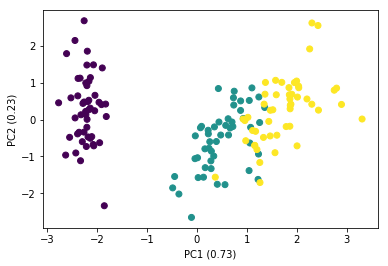

In [137]:
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

iris = load_iris()

data = iris["data"]
labels = iris["target"]

scaler = StandardScaler()
data = scaler.fit_transform(data)

pca = PCA(n_components = 2)
data_reduced = pca.fit_transform(data)

plt.scatter(data_reduced[:,0],data_reduced[:,1], c = iris.target)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2f})")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2f})")

In this labled dataset, we see that the two first principal componants contains ~95% of the variance of the original data.

Now we build an autoencoder network to perform the same task.

In [138]:
def ae_pca(data, encoding_dim):
    n_inputs = data.shape[1]
    n_outputs = n_inputs
    encoding_dim = encoding_dim
    
    learning_rate = 0.01

    X = tf.placeholder(tf.float32, shape = [None,n_inputs])
    hidden = tf.layers.dense(X,encoding_dim)
    outputs = tf.layers.dense(hidden,n_outputs)

    reconstruction_loss = tf.reduce_mean(tf.square(outputs-X))

    adam = tf.train.AdamOptimizer(learning_rate)
    optimizer = adam.minimize(reconstruction_loss)
    init = tf.global_variables_initializer()
    
    epochs = 1000
    encoded = hidden
    data = np.array(data)

    with tf.Session() as sess:
        init.run()
        for iteration in range(epochs):
            optimizer.run(feed_dict={X: data})
    
        encoding_val = encoded.eval(feed_dict={X: data})
    
    return encoding_val
    

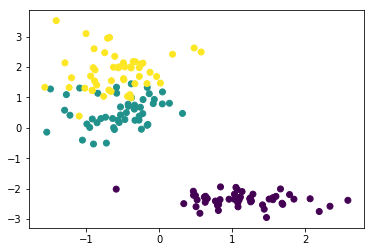

In [140]:
ae_reduced = ae_pca(data,2)
plt.scatter(ae_reduced[:,0],ae_reduced[:,1], c = iris.target)

We see that by using an autoencoder with two encoding neurons and linear activation, we get a dimensional reduction of the data to two dimensions which preserves as much of the original variance of the data, just as we did using PCA.

One advantage of using autoencoders, is that by using non-linear activation function, we can perform dimensional reduction into more complex subspaces, which may result in a larger preservation of the original variance.

### K-means clustering on the dimensionally reduced data

Just to finish of this section, we perform k-means clustering to classify the dimensionally reduced data, to give an example of the benefits of dimensional reduction. 

K-means clustering is quite straight-forward; we randomly generate k-clusters and classify all our datapoints according to which centroid is closest (i.e. all datapoints which have centroid 1 as its nearest centroid is considered to be the same class). Then we move the centroids so that they are placed in the center of the datapoints classifed to that cluster, and repeat the procedure. After repeating this a few times, the centroids will converge to a stationary position, and the classification is finished.

In [143]:
""" Function to calculate the k-means clustering of n-dimensional data.
    Output is:
    
    groups - a list where each element is a list of all datapoints belonging to that group
    centroids - list of the coordinates of all the sentroids
    cluster_variance - the sum of the MSE of all the clusters """

import random

def k_means(data, k, max_iter = 100):
    
    centroids = random.sample(list(data),k)
    n_samples = data.shape[0]
    n_dims = data.shape[1]
    
    iteration = 0
            
    new_centroids = [[] for _ in range(k)]
    dist_list = [[] for _ in range(k)]
    
    while iteration != max_iter:

        groups = [[] for _ in range(k)]
        distance = [[] for _ in range(k)]

        for n in range(n_samples):

            for m in range(k):
                dist_list[m] = sum([(data[n,l]-centroids[m][l])**2 for l in range(n_dims)])
                # The square root of this is the true distance, but the minimum will be the same

            min_dist = min(dist_list)
            label = dist_list.index(min_dist)

            groups[label].append(data[n])
            distance[label].append(min_dist)

        new_centroids = [sum(groups[m])/len(groups[m]) for m in range(k)]
        
        if (np.array(centroids) == np.array(new_centroids)).all():
            print("Done.")
            cluster_variance = sum([sum(distance[m])/len(distance[m]) for m in range(k)])  
            return groups, new_centroids, cluster_variance

        centroids = new_centroids
        
        iteration += 1
        
    print("Failed to converge.")
    return groups, centroids, cluster_variance

In [154]:
test = []
c_variance = []
for n in range(1,7):
    _, _, c_var = k_means(ae_reduced,n,max_iter=100)
    c_variance.append(n)
    test.append(c_var)

Done.
Done.
Done.
Done.
Done.
Done.


What follows is the plot of the sum of the MSE of all the clusters. A rule of thumb for choosing the optimal number of clusters is to choose the point where the MSE stops decreasing, which in this case is 2. Looking at the original data, it is easy to see why two of the clusters (green and yellow) can be classified as a single cluster, but since we know that there are 3 species of iris, the classifier obviously works best with three centroids. This just go to show that one has to be critical when using rule of thumbs.


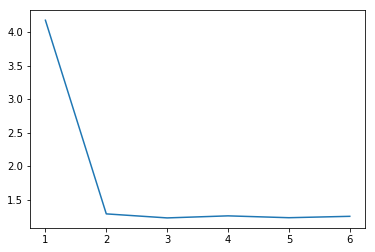

In [158]:
plt.plot(c_variance,test)

Done.


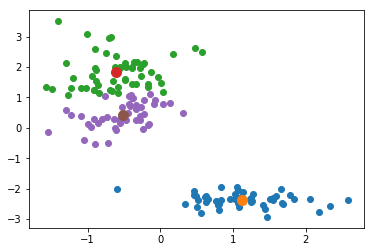

In [159]:
groups, centroids, cluster_variance = k_means(ae_reduced,3)

for m in range(3):
    plt.scatter(np.array(groups[m])[:,0],np.array(groups[m])[:,1])
    plt.scatter(centroids[m][0],centroids[m][1], s = 100)

Now we can compare the classification of our k-means algorithm with the true labels and determine accuracy metrics, precision, etc., but I think the point is clear. So lets move on!

# Autoencoders for denoising

Another usecase for autoencoder is to introduce noise into clean input data, and have the network reproduce the input without noise. The goal is then, that when training on real noisy data (of similar type as the clean data we trained on) the network will be able to perform denoising on it.

The other benefit of adding noise, is that it prevents the autoencoder to trivially copy the input to the output, which can easily happen with large networks and small amounts of data, and forces it to learn generalized features of the data (http://www.jmlr.org/papers/volume11/vincent10a/vincent10a.pdf). This form of regularization can also be perform by adding dropout layers instead of noise. 

In [234]:
from keras.datasets import mnist

img_rows, img_cols = 28,28

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train/255
x_test = x_test/255

Here we use the standard MNIST dataset for illustration. Below we plot the first 5 images of the dataset in the first row, and the same images with added gaussian noise in the second row.

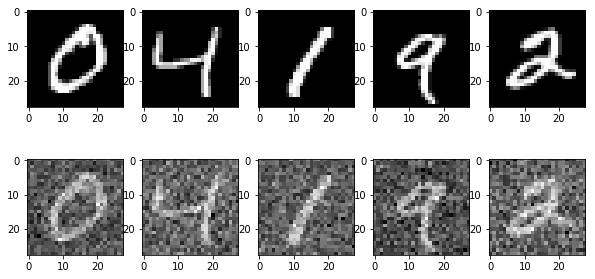

In [273]:
fig = plt.figure(figsize = (10,5))
plt.gray()
noise_level = 0.3

for n in range(1,6):
    
    img = x_train[n].reshape((28,28))
    noise_img = img + noise_level*np.random.normal(0, 1, (28, 28))
    
    plt.subplot(2,5,n)
    plt.imshow(img)
    
    plt.subplot(2,5,n+5)
    plt.imshow(noise_img)

The following autoencoder network takes the MNST data (28x28 imgs on one b/w channel), adds gaussian noise to the input, forces it through a bottleneck, and tries to reconstruct the images as they were before we added noise.

In [300]:
from keras.layers import UpSampling2D, Conv2D, MaxPooling2D, Input
from keras import Model

input_img = Input(shape=(28, 28, 1))
input_noise = keras.layers.GaussianNoise(stddev=0.4)(input_img)

conv1 = Conv2D(32, (3, 3), activation="relu", padding="same")(input_noise)
maxp1 = MaxPooling2D((2, 2))(conv1)
conv2 = Conv2D(16, (3, 3), activation="relu", padding="same")(maxp1)
maxp2 = MaxPooling2D((2, 2))(conv2)

encoded = Conv2D(8, (3, 3), activation="relu", padding="same", name = "encoded")(maxp2)

upsamp1 = UpSampling2D((2, 2))(encoded)
upconv2 = Conv2D(16,(3,3),activation ="relu", padding="same")(upsamp1)
upsamp2 = UpSampling2D((2, 2))(upconv2)
unconv3 = Conv2D(32,(3,3), activation ="sigmoid", padding="same")(upsamp2)


decoded = Conv2D(1,(3,3), activation ="sigmoid", padding="same")(unconv3)

encoder = Model(input_img,encoded)
autoencoder = Model(input_img,decoded)

autoencoder.compile(optimizer='adam', loss='mse')

In [301]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
gaussian_noise_15 (GaussianN (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_111 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_112 (Conv2D)          (None, 14, 14, 16)        4624      
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 7, 7, 16)          0         
_________________________________________________________________
encoded (Conv2D)             (None, 7, 7, 8)           1160      
__________

In this summary we see the original input shape of 28x28x1 images (784 neurons) is compressed to the encoding layer with 7x7x8 (392 neurons), so the compression factor is about 2. We use upsampling and a final convolution layer with 1 filter to get the output back into the same 28x28 shape as the input. Notice that the network is not perfectly symmetric about the encoding layer, but this is not strictly nessecary since we are not tying the weights.

In [302]:
history = autoencoder.fit(x_train,x_train,
                           batch_size = 512,
                           epochs = 5,
                           validation_data = (x_test,x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 244s 4ms/step - loss: 0.1168 - val_loss: 0.0935
Epoch 2/5
60000/60000 [==============================] - 244s 4ms/step - loss: 0.0584 - val_loss: 0.0352
Epoch 3/5
60000/60000 [==============================] - 239s 4ms/step - loss: 0.0271 - val_loss: 0.0216
Epoch 4/5
60000/60000 [==============================] - 240s 4ms/step - loss: 0.0197 - val_loss: 0.0153
Epoch 5/5
60000/60000 [==============================] - 240s 4ms/step - loss: 0.0172 - val_loss: 0.0128


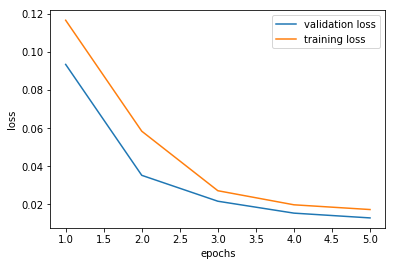

In [306]:
plt.plot([1,2,3,4,5], history.history["val_loss"])
plt.plot([1,2,3,4,5], history.history["loss"])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["validation loss","training loss"])

Already here we can see that the noise acts as a regularizer for the network, since the validation and training losses are quite close.

Below we plot the reconstructed images (top row) and their corresponding input images (lower row). Although a bit fussy (which is essentially unavoidable when compressing data), the data is reconstructed quite well.

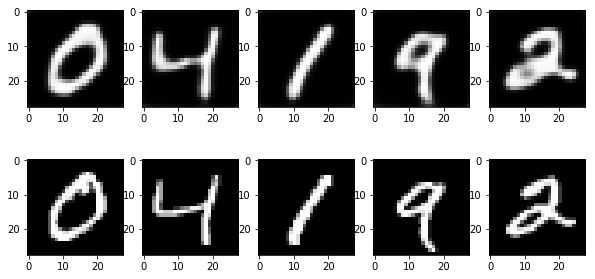

In [310]:
fig = plt.figure(figsize = (10,5))
plt.gray()

for n in range(1,6):
    img = x_train[n].reshape((28,28))
    ae_img = autoencoder.predict(img.reshape((1,28,28,1)))

    plt.subplot(2,5,n)
    plt.imshow(ae_img.reshape(28,28))

    plt.subplot(2,5,n+5)
    plt.imshow(img)

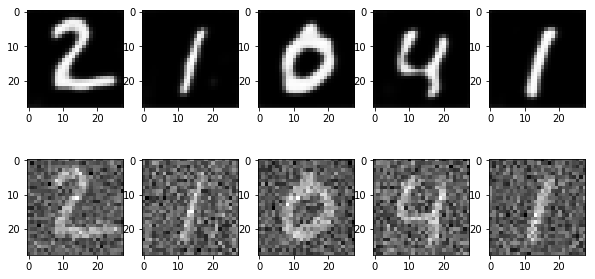

In [330]:
fig = plt.figure(figsize = (10,5))
plt.gray()

noise_level = 0.3

for n in range(1,6):
    
    img = x_test[n] + noise_level*np.random.normal(0, 1, (28, 28,1))
    
    ae_img = autoencoder.predict(img.reshape((1,28,28,1)))

    plt.subplot(2,5,n)
    plt.imshow(ae_img.reshape(28,28))

    plt.subplot(2,5,n+5)
    plt.imshow(img.reshape(28,28))

Here we plot the noisy input data (test data that the network has not trained on) in the lower row, as well as the reconstructed data in the top row. The output is indeed clearly denoised, and still quite legible. Finally below, we plot how the denoising autoencoder performs as we increase the noise level.

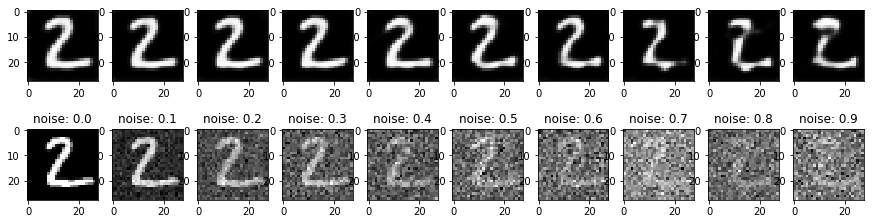

In [352]:
fig = plt.figure(figsize = (15,4))
plt.gray()

noise_level = [0.1*n for n in range(10)]

for n in range(1,11):
    
    img = x_test[1] + noise_level[n-1]*np.random.normal(0, 1, (28, 28,1))
    
    ae_img = autoencoder.predict(img.reshape((1,28,28,1)))

    plt.subplot(2,10,n)
    plt.imshow(ae_img.reshape(28,28))

    plt.subplot(2,10,n+10)
    plt.imshow(img.reshape(28,28))
    plt.title(f"noise: {noise_level[n-1]:.1f}")

The denoising is rather exceptional, even when the numbers becomes almost illegible for human eyes.